<a href="https://www.kaggle.com/code/goharpetrosyan06/lung-segmentation-v2-tensorflow?scriptVersionId=237919594" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [47]:
import numpy as np 
import tensorflow as tf
import pandas as pd
import os
from cv2 import imread
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras import backend as keras
from keras.models import load_model

In [48]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [49]:
model = unet(input_size=(512,512,1))
model.load_weights("/kaggle/input/best_model_tensorflow/tensorflow2/default/1/cxr_reg_weights.best.hdf5")

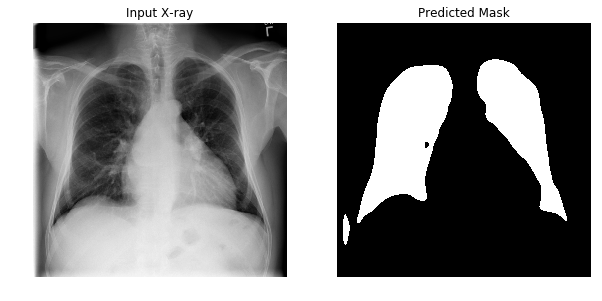

In [50]:
def predict_mask_for_image(image_path, model, input_size=512, threshold=0.5, show=False):
    target_size = (input_size, input_size)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)
    img_norm = (img_resized.astype(np.float32) - 127.0) / 127.0
    x = img_norm.reshape(1, 512, 512, 1)
    y_pred = model.predict(x)
    y_pred = y_pred.squeeze()
    
    mask_pred = y_pred.astype(np.uint8) * 255 #(y_pred >= threshold).astype(np.uint8) * 255

    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(img_resized, cmap='gray')
        ax1.set_title("Input X‑ray");  ax1.axis('off')
        ax2.imshow(mask_pred, cmap='gray')
        ax2.set_title("Predicted Mask");  ax2.axis('off')
        plt.show()

    return mask_pred


mask = predict_mask_for_image("/kaggle/input/data/images_001/images/00000001_000.png",
                              model,
                              input_size=512,
                              threshold=0.5,
                              show=True)


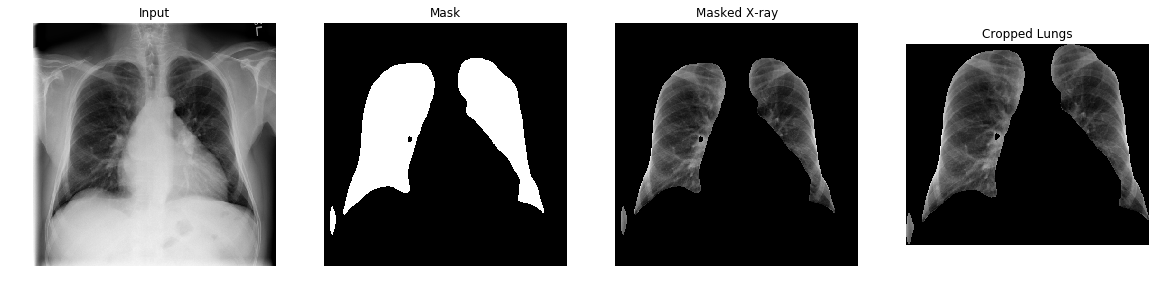

In [51]:
def predict_and_cut_lungs(image_path, model, input_size=512, threshold=0.5, show=False):    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (input_size, input_size))
    img_norm = (img_resized.astype(np.float32) - 127.0) / 127.0
    x = img_norm.reshape(1, 512, 512, 1)
    y_pred = model.predict(x).squeeze()
    
    mask_bin = y_pred.astype(np.uint8)#(y_pred >= threshold).astype(np.uint8)
    mask_uint8 = mask_bin * 255

    lung_only = cv2.bitwise_and(img_resized, img_resized, mask=mask_uint8)

    cnts, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    h, w = mask_bin.shape
    x_min, y_min = w, h
    x_max = y_max = 0
    for c in cnts:
        x, y, cw, ch = cv2.boundingRect(c)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + cw)
        y_max = max(y_max, y + ch)
        
    lung_cropped = lung_only[y_min:y_max, x_min:x_max]

    if show:
        fig, axes = plt.subplots(1, 4, figsize=(20,5))
        axes[0].imshow(img_resized, cmap='gray');       axes[0].set_title("Input")
        axes[1].imshow(mask_uint8, cmap='gray');       axes[1].set_title("Mask")
        axes[2].imshow(lung_only, cmap='gray');        axes[2].set_title("Masked X‑ray")
        axes[3].imshow(lung_cropped, cmap='gray');     axes[3].set_title("Cropped Lungs")
        for ax in axes: ax.axis('off')
        plt.show()

    return lung_cropped
    
mask = predict_and_cut_lungs("/kaggle/input/data/images_001/images/00000001_000.png",
                              model,
                              input_size=512,
                              threshold=0.5,
                              show=True)